In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load daily feature table from Google Drive
df = pd.read_csv("/content/drive/MyDrive/capstone-data/cleaned_combined_data_2007.csv", parse_dates=['datetime'])
df.set_index('datetime', inplace=True)
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,windspeed,cloudcover
datetime,,,,,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0,13.9,86.47,30.9,95.5
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0,14.0,85.10,25.5,96.9
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0,14.0,84.29,27.7,92.7
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0,13.8,80.82,21.7,67.7
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0,12.9,59.76,26.8,23.7


In [ ]:
ts = df['Global_active_power'].resample('D').mean()

# Drop missing values
ts = ts.dropna()


**Check stationarity**


In [ ]:
result = adfuller(ts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is non-stationary. Differencing required.")
    ts_diff = ts.diff().dropna()

    # Check again after differencing
    result_diff = adfuller(ts_diff)
    print("ADF Statistic after differencing:", result_diff[0])
    print("p-value after differencing:", result_diff[1])
else:
    print("Series is stationary. No differencing needed.")
    ts_diff = ts  # Use original if already stationary


ADF Statistic: -3.46423989191217
p-value: 0.008954411573732954
Series is stationary. No differencing needed.


**Interpretation**

If p-value < 0.05, data is stationary → **proceed**.

If p-value ≥ 0.05, data is non-stationary → need to difference or transform.

**ARIMA**

In [ ]:
# Train-test split
train = ts_diff[:'2007-11-30']
test = ts_diff['2007-12-01':]

train.index = pd.to_datetime(train.index)
train = train.asfreq('D')

In [ ]:
model = ARIMA(train, order=(6, 1, 5))  # Adjust (p,d,q) if needed
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                  334
Model:                  ARIMA(6, 1, 5)   Log Likelihood                -136.488
Date:                 Wed, 16 Jul 2025   AIC                            296.976
Time:                         19:36:51   BIC                            342.674
Sample:                     01-01-2007   HQIC                           315.198
                          - 11-30-2007                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1614      0.400     -0.403      0.687      -0.945       0.623
ar.L2         -0.6504      0.174     -3.731      0.000      -0.992      -0.309
ar.L3         -0.2231      0.167     -1.339 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



**Forecast**

In [ ]:
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

In [ ]:
# Forecast for next 30 days
future_steps = 30
future_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
forecast_future = model_fit.forecast(steps=future_steps)
forecast_future = pd.Series(forecast_future.values, index=future_index)


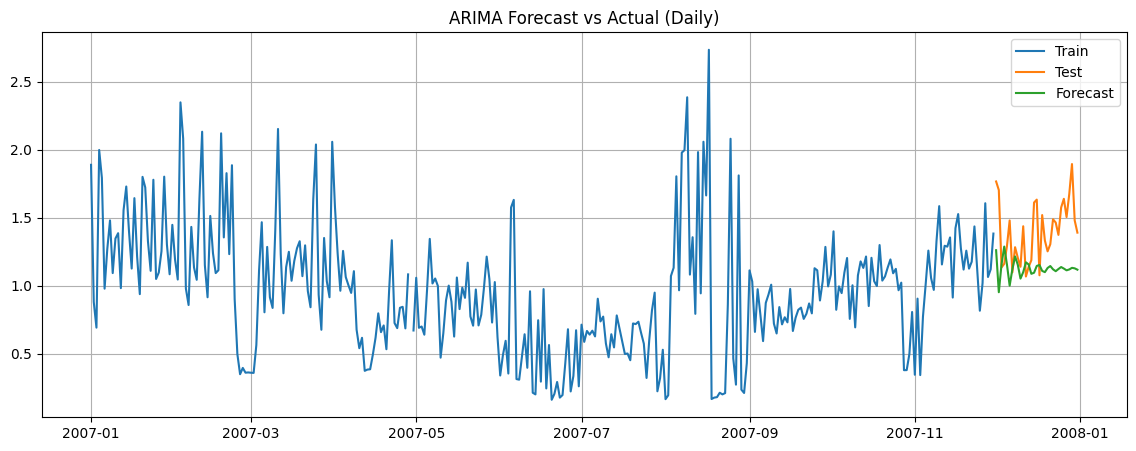

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.title("ARIMA Forecast vs Actual (Daily)")
plt.legend()
plt.grid(True)
plt.show()

**Evaluate**

In [ ]:
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


MSE: 0.13
MAE: 0.29


**Anomaly detection**


Anomalies (sudden drops):
datetime
2007-06-07   -1.318202
2007-06-13   -0.746133
2007-06-18   -0.730767
2007-06-20   -0.402767
2007-07-29   -0.725570
2007-08-18   -2.568967
2007-08-26   -1.614949
2007-08-29   -1.575839
Name: Global_active_power, dtype: float64


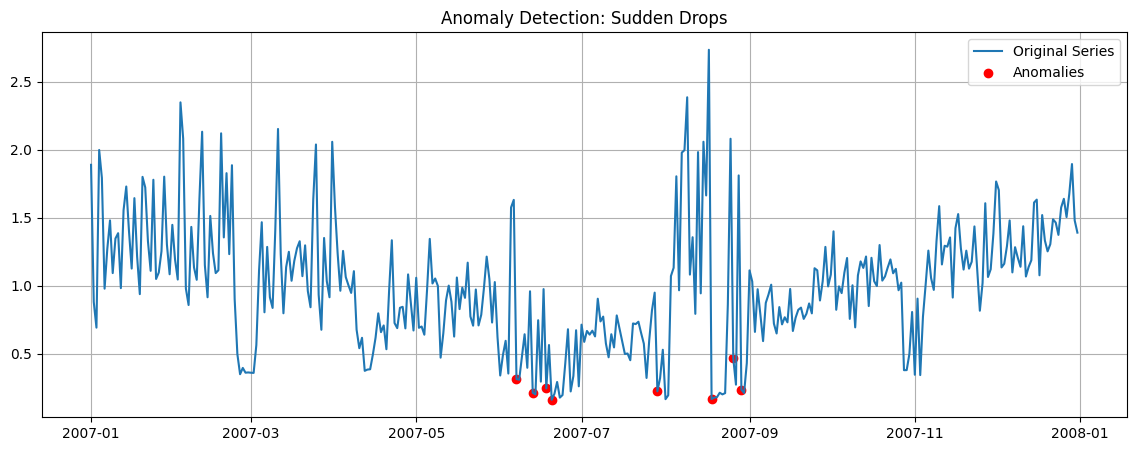

In [ ]:
ts_diff_all = ts.diff()
anomalies = ts_diff_all[ts_diff_all < -0.7 * ts.shift(1)]

print("\nAnomalies (sudden drops):")
print(anomalies)

# Plot anomalies
plt.figure(figsize=(14, 5))
plt.plot(ts, label='Original Series')
plt.scatter(anomalies.index, ts.loc[anomalies.index], color='red', label='Anomalies')
plt.title("Anomaly Detection: Sudden Drops")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# saving consumption and predicted data

df_combined = pd.DataFrame({
    'datetime': ts.index,
    'consumption': ts.values
})
df_combined.set_index('datetime', inplace=True)
df_combined['forecast'] = forecast


future_df = pd.DataFrame({
    'consumption': [None] * future_steps,
    'forecast': forecast_future.values
}, index=future_index)

final_df = pd.concat([df_combined, future_df])
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'datetime'}, inplace=True)

# Save to CSV
final_df.to_csv("/content/drive/MyDrive/capstone-data/arima_model_forecast.csv", index=False)



/tmp/ipython-input-44-4259640460.py:16: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

